#Stock Market Prediction using Numerical & Textual analysis

(Using LSTM)

Mayur Veer

m.veer@somaiya.edu

https://www.linkedin.com/in/mayur-veer-a66838185/

Date: 14th March, 2021

**Datasets used**:

1.Historical stock prices *italicized text*: https://in.finance.yahoo.com/quote/%5EIXIC/history?period1=978307200&period2=1616025600&interval=1mo&filter=history&frequency=1mo&includeAdjustedClose=true

2.Textual News Headline: https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/DPQMQH

#Importing libraries

In [ ]:
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, LSTM

import nltk
nltk.downloader.download('vader_lexicon')
from nltk.classify import NaiveBayesClassifier
from nltk.corpus import subjectivity
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.util import *

from sklearn import preprocessing, metrics
from sklearn.preprocessing import MinMaxScaler

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


#Importing the datasets

In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
downloaded = drive.CreateFile({'id':'1SCKgycegIolyvuGv8adyQ37iDVdNj5wD'}) # replace the id with id of file you want to access
downloaded.GetContentFile('india-news-headlines.csv')
downloaded1 = drive.CreateFile({'id':'1RubYKUkAONSKTVmQxMked0krTjaPpiDe'}) # replace the id with id of file you want to access
downloaded1.GetContentFile('^IXIC.csv')

#Datasets

Importing stock price dataset and displaying it

In [ ]:
s_p = pd.read_csv('^IXIC.csv')
s_p.head()

Importing headlines dataset and displaying it

In [ ]:
s_h = pd.read_csv('india-news-headlines.csv')
s_h.head()

Displaying no. of rows and columns

In [ ]:
print(s_p.shape)
print(s_h.shape)

Checking for null values in both datasets

In [ ]:
s_p.isna().any(), s_h.isna().any()

#Combining both datasets

Stock price dataset

In [ ]:
# dropping duplicates
s_p = s_p.drop_duplicates()

# coverting the datatype of column 'Date' from type object to type 'datetime'
s_p['Date'] = pd.to_datetime(s_p['Date']).dt.normalize()

# filtering the important columns required
s_p = s_p.filter(['Date', 'Close', 'Open', 'High', 'Low', 'Volume'])

# setting column 'Date' as the index column
s_p.set_index('Date', inplace= True)

# sorting the data according to the index i.e 'Date'
s_p = s_p.sort_index(ascending=True, axis=0)
s_p

Headlines dataset

In [ ]:
# dropping duplicates
s_h = s_h.drop_duplicates()

# coverting the datatype of column 'Date' from type string to type 'datetime'
s_h['publish_date'] = s_h['publish_date'].astype(str)
s_h['publish_date'] = s_h['publish_date'].apply(lambda x: x[0:4]+'-'+x[4:6]+'-'+x[6:8])
s_h['publish_date'] = pd.to_datetime(s_h['publish_date']).dt.normalize()

# filtering the important columns required
s_h = s_h.filter(['publish_date', 'headline_text'])

# grouping the news headlines according to 'Date'
s_h = s_h.groupby(['publish_date'])['headline_text'].apply(lambda x: ','.join(x)).reset_index()

# setting column 'Date' as the index column
s_h.set_index('publish_date', inplace= True)

# sorting the data according to the index i.e 'Date'
s_h = s_h.sort_index(ascending=True, axis=0)
s_h

Combining both datasets

In [ ]:
# concatenating the datasets stock_price and stock_headlines
s_d = pd.concat([s_p, s_h], axis=1)

# dropping the null values if any
s_d.dropna(axis=0, inplace=True)

# displaying the combined stock_data
s_d

Calculating Sentiment scores

In [ ]:
# adding empty sentiment columns to stock_data for later calculation
s_d['compound'] = ''
s_d['negative'] = ''
s_d['neutral'] = ''
s_d['positive'] = ''
s_d.head()

In [ ]:
# importing requires libraries to analyze the sentiments
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import unicodedata

# instantiating the Sentiment Analyzer
sid = SentimentIntensityAnalyzer()

# calculating sentiment scores
s_d['compound'] = s_d['headline_text'].apply(lambda x: sid.polarity_scores(x)['compound'])
s_d['negative'] = s_d['headline_text'].apply(lambda x: sid.polarity_scores(x)['neg'])
s_d['neutral'] = s_d['headline_text'].apply(lambda x: sid.polarity_scores(x)['neu'])
s_d['positive'] = s_d['headline_text'].apply(lambda x: sid.polarity_scores(x)['pos'])

# displaying the stock data
s_d.head()

,Close,Open,High,Low,Volume,headline_text,compound,negative,neutral,positive
2001-01-02,2291.860107,2474.159912,2474.159912,2273.070068,1.918930e+09,Status quo will not be disturbed at Ayodhya; s...,-0.9621,0.119,0.817,0.064
2001-01-03,2616.689941,2254.560059,2618.030029,2251.709961,3.188000e+09,"Powerless north India gropes in the dark,Think...",0.6322,0.084,0.817,0.098
2001-01-04,2566.830078,2593.959961,2644.800049,2549.830078,2.610680e+09,The string that pulled Stephen Hawking to Indi...,0.6648,0.077,0.843,0.080
2001-01-05,2407.649902,2573.110107,2574.620117,2395.389893,2.104670e+09,Light combat craft takes India into club class...,0.9032,0.105,0.746,0.149
2001-01-08,2395.919922,2388.719971,2397.060059,2299.649902,1.850590e+09,"Sangh Parivar; Babri panel up the ante,Frontru...",-0.9638,0.119,0.855,0.026


Editing the combined dataset

In [ ]:
# dropping the 'headline_text' which is unwanted now
s_d.drop(['headline_text'], inplace=True, axis=1)

# rearranging the columns of the whole stock_data
s_d = s_d[['Close', 'compound', 'negative', 'neutral', 'positive', 'Open', 'High', 'Low', 'Volume']]

# displaying the final stock_data
s_d.head()

,Close,compound,negative,neutral,positive,Open,High,Low,Volume
2001-01-02,2291.860107,-0.9621,0.119,0.817,0.064,2474.159912,2474.159912,2273.070068,1.918930e+09
2001-01-03,2616.689941,0.6322,0.084,0.817,0.098,2254.560059,2618.030029,2251.709961,3.188000e+09
2001-01-04,2566.830078,0.6648,0.077,0.843,0.080,2593.959961,2644.800049,2549.830078,2.610680e+09
2001-01-05,2407.649902,0.9032,0.105,0.746,0.149,2573.110107,2574.620117,2395.389893,2.104670e+09
2001-01-08,2395.919922,-0.9638,0.119,0.855,0.026,2388.719971,2397.060059,2299.649902,1.850590e+09


Displaying the no. of rows and columns of the combined dataset

In [ ]:
s_d.shape

(4877, 9)

Checking for null values

In [ ]:
s_d.isna().any()

Close       False
compound    False
negative    False
neutral     False
positive    False
Open        False
High        False
Low         False
Volume      False
dtype: bool

Displaying statistics

In [ ]:
s_d.describe()

,Close,compound,negative,neutral,positive,Open,High,Low,Volume
count,4877.000000,4877.000000,4877.000000,4877.000000,4877.000000,4877.000000,4877.000000,4877.000000,4.877000e+03
mean,3599.962867,-0.870185,0.125720,0.788116,0.086175,3599.296674,3622.418950,3574.214235,1.983753e+09
std,2111.459454,0.453365,0.024431,0.033153,0.020881,2110.518798,2121.462407,2098.982309,5.235038e+08
min,1114.109985,-1.000000,0.000000,0.000000,0.000000,1116.760010,1135.890015,1108.489990,1.494100e+08
25%,2073.590088,-0.999800,0.112000,0.768000,0.075000,2075.550049,2089.000000,2058.520020,1.704220e+09
50%,2611.229980,-0.999000,0.127000,0.785000,0.086000,2613.510010,2630.510010,2593.040039,1.911420e+09
75%,4862.569824,-0.994100,0.141000,0.806000,0.096000,4856.689941,4889.209961,4836.459961,2.161400e+09
max,10131.370117,1.000000,0.444000,1.000000,0.608000,10130.830078,10221.849609,10112.440430,7.279230e+09


Displaying information

In [ ]:
s_d.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4877 entries, 2001-01-02 to 2020-06-30
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Close     4877 non-null   float64
 1   compound  4877 non-null   float64
 2   negative  4877 non-null   float64
 3   neutral   4877 non-null   float64
 4   positive  4877 non-null   float64
 5   Open      4877 non-null   float64
 6   High      4877 non-null   float64
 7   Low       4877 non-null   float64
 8   Volume    4877 non-null   float64
dtypes: float64(9)
memory usage: 381.0 KB


#Stock data plot

Text(0, 0.5, 'Close Price ($)')

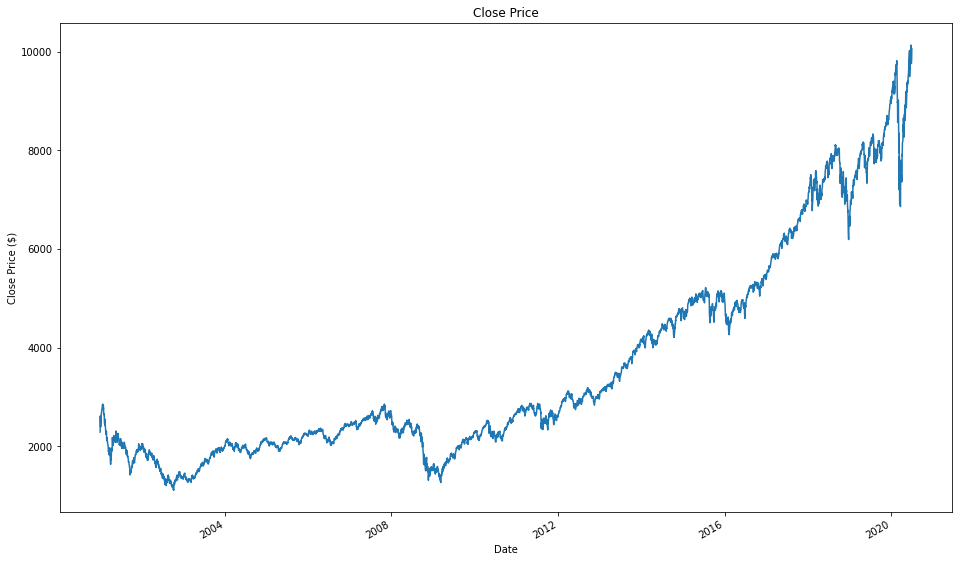

In [ ]:
# setting figure size
plt.figure(figsize=(16,10))

# plotting close price
s_d['Close'].plot()

# setting plot title, x and y labels
plt.title("Close Price")
plt.xlabel('Date')
plt.ylabel('Close Price ($)')

#Modelling

In [ ]:
# calculating data_to_use
percentage_of_data = 1.0
data_to_use = int(percentage_of_data*(len(s_d)-1))

# using 80% of data for training
train_end = int(data_to_use*0.8)
total_data = len(s_d)
start = total_data - data_to_use

# printing number of records in the training and test datasets
print("Number of records in Training Data:", train_end)
print("Number of records in Test Data:", total_data - train_end)

Number of records in Training Data: 3900
Number of records in Test Data: 977


In [ ]:
# predicting one step ahead
steps_to_predict = 1

# capturing data to be used for each column
close_price = s_d.iloc[start:total_data,0] #close
compound = s_d.iloc[start:total_data,1] #compound
negative = s_d.iloc[start:total_data,2] #neg
neutral = s_d.iloc[start:total_data,3] #neu
positive = s_d.iloc[start:total_data,4] #pos
open_price = s_d.iloc[start:total_data,5] #open
high = s_d.iloc[start:total_data,6] #high
low = s_d.iloc[start:total_data,7] #low
volume = s_d.iloc[start:total_data,8] #volume

# printing close price
print("Close Price:")
close_price

Close Price:


2001-01-03     2616.689941
2001-01-04     2566.830078
2001-01-05     2407.649902
2001-01-08     2395.919922
2001-01-09     2441.300049
                  ...     
2020-06-24     9909.169922
2020-06-25    10017.000000
2020-06-26     9757.219727
2020-06-29     9874.150391
2020-06-30    10058.769531
Name: Close, Length: 4876, dtype: float64

In [ ]:
# shifting next day close
close_price_shifted = close_price.shift(-1) 

# shifting next day compound
compound_shifted = compound.shift(-1) 

# concatenating the captured training data into a dataframe
data = pd.concat([close_price, close_price_shifted, compound, compound_shifted, volume, open_price, high, low], axis=1)

# setting column names of the revised stock data
data.columns = ['close_price', 'close_price_shifted', 'compound', 'compound_shifted','volume', 'open_price', 'high', 'low']

# dropping nulls
data = data.dropna()    
data.head(10)

,close_price,close_price_shifted,compound,compound_shifted,volume,open_price,high,low
2001-01-03,2616.689941,2566.830078,0.6322,0.6648,3.188000e+09,2254.560059,2618.030029,2251.709961
2001-01-04,2566.830078,2407.649902,0.6648,0.9032,2.610680e+09,2593.959961,2644.800049,2549.830078
2001-01-05,2407.649902,2395.919922,0.9032,-0.9638,2.104670e+09,2573.110107,2574.620117,2395.389893
2001-01-08,2395.919922,2441.300049,-0.9638,-0.9559,1.850590e+09,2388.719971,2397.060059,2299.649902
2001-01-09,2441.300049,2524.179932,-0.9559,-0.5719,1.975130e+09,2424.689941,2474.159912,2406.080078
2001-01-10,2524.179932,2640.570068,-0.5719,0.0000,2.470350e+09,2392.709961,2525.280029,2376.489990
2001-01-11,2640.570068,2840.389893,0.0000,0.9295,2.842640e+09,2495.590088,2661.929932,2495.010010
2001-01-23,2840.389893,2859.149902,0.9295,-0.9039,2.278470e+09,2759.260010,2845.389893,2736.280029
2001-01-24,2859.149902,2754.280029,-0.9039,-0.9854,2.567320e+09,2850.739990,2892.360107,2828.320068
2001-01-25,2754.280029,2781.300049,-0.9854,0.8926,2.298150e+09,2836.350098,2849.560059,2753.370117


#Target variable and feature dataset

In [ ]:
# setting the target variable as the shifted close_price
y = data['close_price_shifted']
y

2001-01-03     2566.830078
2001-01-04     2407.649902
2001-01-05     2395.919922
2001-01-08     2441.300049
2001-01-09     2524.179932
                  ...     
2020-06-23     9909.169922
2020-06-24    10017.000000
2020-06-25     9757.219727
2020-06-26     9874.150391
2020-06-29    10058.769531
Name: close_price_shifted, Length: 4875, dtype: float64

In [ ]:
# setting the features dataset for prediction  
cols = ['close_price', 'compound', 'compound_shifted', 'volume', 'open_price', 'high', 'low']
x = data[cols]
x

,close_price,compound,compound_shifted,volume,open_price,high,low
2001-01-03,2616.689941,0.6322,0.6648,3.188000e+09,2254.560059,2618.030029,2251.709961
2001-01-04,2566.830078,0.6648,0.9032,2.610680e+09,2593.959961,2644.800049,2549.830078
2001-01-05,2407.649902,0.9032,-0.9638,2.104670e+09,2573.110107,2574.620117,2395.389893
2001-01-08,2395.919922,-0.9638,-0.9559,1.850590e+09,2388.719971,2397.060059,2299.649902
2001-01-09,2441.300049,-0.9559,-0.5719,1.975130e+09,2424.689941,2474.159912,2406.080078
...,...,...,...,...,...,...,...
2020-06-23,10131.370117,-0.9999,-0.9997,5.712450e+09,10130.830078,10221.849609,10112.440430
2020-06-24,9909.169922,-0.9997,-0.9999,5.549440e+09,10092.919922,10137.500000,9842.219727
2020-06-25,10017.000000,-0.9999,-0.9999,4.709620e+09,9899.360352,10023.280273,9810.469727
2020-06-26,9757.219727,-0.9999,-0.9997,7.279230e+09,9995.120117,10000.669922,9749.070313


Scaling the target variable and feature dataset, since we are using LSTM to predict stock market prices

In [ ]:
# scaling the feature dataset
scaler_x = preprocessing.MinMaxScaler (feature_range=(-1, 1))
x = np.array(x).reshape((len(x) ,len(cols)))
x = scaler_x.fit_transform(x)

# scaling the target variable
scaler_y = preprocessing.MinMaxScaler (feature_range=(-1, 1))
y = np.array (y).reshape ((len( y), 1))
y = scaler_y.fit_transform (y)

# displaying the scaled feature dataset and the target variable
x, y

(array([[-0.66673248,  0.6322    ,  0.6648    , ..., -0.74755021,
         -0.67375157, -0.74606258],
        [-0.67779124,  0.6648    ,  0.9032    , ..., -0.67224574,
         -0.66785896, -0.67984273],
        [-0.71309691,  0.9032    , -0.9638    , ..., -0.6768718 ,
         -0.68330696, -0.71414772],
        ...,
        [ 0.97463307, -0.9999    , -0.9999    , ...,  0.94864257,
          0.95629095,  0.93292484],
        [ 0.91701462, -0.9999    , -0.9997    , ...,  0.9698893 ,
          0.95131396,  0.91928651],
        [ 0.94294947, -0.9997    , -0.9998    , ...,  0.92032226,
          0.92416656,  0.90030374]]), array([[-0.67779124],
        [-0.71309691],
        [-0.71569858],
        ...,
        [ 0.91701462],
        [ 0.94294947],
        [ 0.98389742]]))

Dividing the dataset into training and testing datasets

In [ ]:
# preparing training and test dataset
X_train = x[0 : train_end,]
X_test = x[train_end+1 : len(x),]    
y_train = y[0 : train_end] 
y_test = y[train_end+1 : len(y)]  

# printing the shape of the training and the test datasets
print('Number of rows and columns in the Training set X:', X_train.shape, 'and y:', y_train.shape)
print('Number of rows and columns in the Test set X:', X_test.shape, 'and y:', y_test.shape)

Number of rows and columns in the Training set X: (3900, 7) and y: (3900, 1)
Number of rows and columns in the Test set X: (974, 7) and y: (974, 1)


Reshaping the feature dataset

In [ ]:
# reshaping the feature dataset for feeding into the model
X_train = X_train.reshape (X_train.shape + (1,)) 
X_test = X_test.reshape(X_test.shape + (1,))

# printing the re-shaped feature dataset
print('Shape of Training set X:', X_train.shape)
print('Shape of Test set X:', X_test.shape)

Shape of Training set X: (3900, 7, 1)
Shape of Test set X: (974, 7, 1)


#Stock data modelling

In [ ]:
# setting the seed to achieve consistent and less random predictions at each execution
np.random.seed(2016)

# setting the model architecture
model=Sequential()
model.add(LSTM(100,return_sequences=True,activation='tanh',input_shape=(len(cols),1)))
model.add(Dropout(0.1))
model.add(LSTM(100,return_sequences=True,activation='tanh'))
model.add(Dropout(0.1))
model.add(LSTM(100,activation='tanh'))
model.add(Dropout(0.1))
model.add(Dense(1))

# printing the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 7, 100)            40800     
_________________________________________________________________
dropout (Dropout)            (None, 7, 100)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 7, 100)            80400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 100)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1

In [ ]:
# compiling the model
model.compile(loss='mse' , optimizer='adam')

# fitting the model using the training dataset
model.fit(X_train, y_train, validation_split=0.2, epochs=10, batch_size=8, verbose=1)

Epoch 1/10
390/390 [==============================] - 8s 14ms/step - loss: 0.0521 - val_loss: 0.1957
Epoch 2/10
390/390 [==============================] - 4s 11ms/step - loss: 0.0115 - val_loss: 0.0521
Epoch 3/10
390/390 [==============================] - 4s 11ms/step - loss: 0.0029 - val_loss: 0.0152
Epoch 4/10
390/390 [==============================] - 4s 11ms/step - loss: 0.0017 - val_loss: 0.0078
Epoch 5/10
390/390 [==============================] - 4s 11ms/step - loss: 0.0015 - val_loss: 0.0063
Epoch 6/10
390/390 [==============================] - 4s 11ms/step - loss: 0.0013 - val_loss: 0.0046
Epoch 7/10
390/390 [==============================] - 4s 11ms/step - loss: 0.0012 - val_loss: 0.0014
Epoch 8/10
390/390 [==============================] - 4s 11ms/step - loss: 0.0011 - val_loss: 4.5016e-04
Epoch 9/10
390/390 [==============================] - 4s 11ms/step - loss: 0.0011 - val_loss: 0.0017
Epoch 10/10
390/390 [==============================] - 5s 12ms/step - loss: 0.0013 - va

#Predictions

In [ ]:
# performing predictions
predictions = model.predict(X_test) 

# unscaling the predictions
predictions = scaler_y.inverse_transform(np.array(predictions).reshape((len(predictions), 1)))

# printing the predictions
print('Predictions:')
predictions[0:5]

Predictions:


array([[5206.4883],
       [5194.2163],
       [5203.0986],
       [5202.706 ],
       [5205.527 ]], dtype=float32)

#Model evaluation

In [ ]:
# calculating the training mean-squared-error
train_loss = model.evaluate(X_train, y_train, batch_size = 1)

# calculating the test mean-squared-error
test_loss = model.evaluate(X_test, y_test, batch_size = 1)

# printing the training and the test mean-squared-errors
print('Train Loss =', round(train_loss,4))
print('Test Loss =', round(test_loss,4))

974/974 [==============================] - 2s 2ms/step - loss: 0.0020
Train Loss = 0.0001
Test Loss = 0.002


In [ ]:
# calculating root mean squared error
root_mean_square_error = np.sqrt(np.mean(np.power((y_test - predictions),2)))
print('Root Mean Square Error =', round(root_mean_square_error,4))

Root Mean Square Error = 7197.7751


In [ ]:
# calculating root mean squared error using sklearn.metrics package
rmse = metrics.mean_squared_error(y_test, predictions)
print('Root Mean Square Error (sklearn.metrics) =', round(np.sqrt(rmse),4))

Root Mean Square Error (sklearn.metrics) = 7197.7751


#Plotting against unseen data

In [ ]:
# unscaling the test feature dataset, x_test
X_test = scaler_x.inverse_transform(np.array(X_test).reshape((len(X_test), len(cols))))

# unscaling the test y dataset, y_test
y_train = scaler_y.inverse_transform(np.array(y_train).reshape((len(y_train), 1)))
y_test = scaler_y.inverse_transform(np.array(y_test).reshape((len(y_test), 1)))

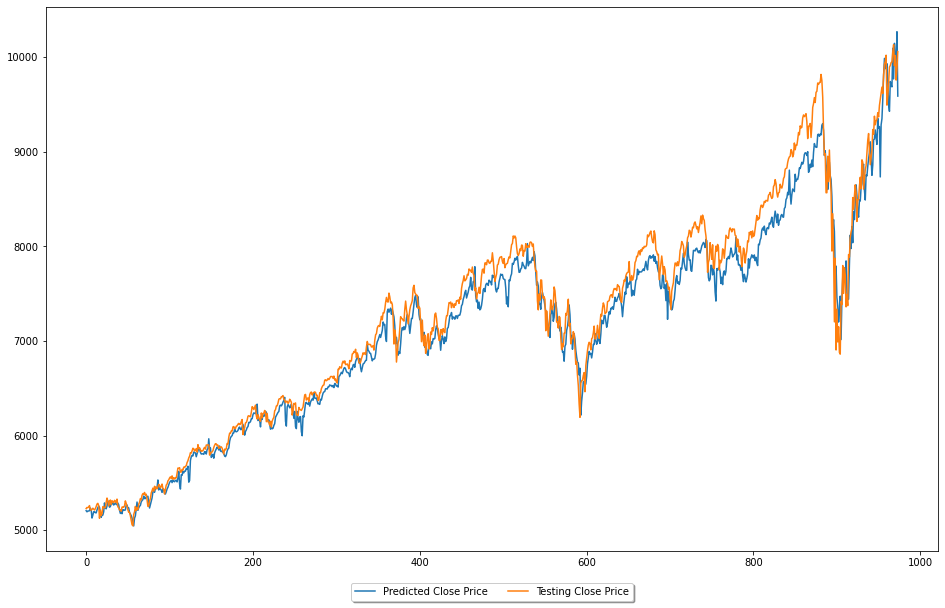

In [ ]:
# plotting
plt.figure(figsize=(16,10))

# plt.plot([row[0] for row in y_train], label="Training Close Price")
plt.plot(predictions, label="Predicted Close Price")
plt.plot([row[0] for row in y_test], label="Testing Close Price")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=2)
plt.show()

#References

https://www.youtube.com/watch?v=MqohgHg3h6Q&t=2s

https://www.analyticsvidhya.com/blog/2018/10/predicting-stock-price-machine-learningnd-deep-learning-techniques-python/